In part 1 of this tutorial, you have evaluted a single sunscan and obtained one pair of corresponding scanner and celestial coordinates. This pair describes the mispointing in one specific part of the sky. However, it is possible that your scanner is accurate in one part of the sky, but has a mispointing in another part. The details depend on the specific parameters of your scanner, like the tilt of the stand or the alignment of the two axes. In this part of the tutorial, we are going to estimate the scanner parameters based on multiple sunscans. 

At first, you have to perform sunscans over the course of a full day. Evaluate each scan according to the tutorial part 1. You will obtain a calibrated pair of scanner and sky coordinates. Please load those coordinates in the form of four 1D numpy arrays:
- `gamma_s`, `omega_s`: "azimuth" and "elevation" position of the scanner in degrees
- `azi_beam`, `elv_beam`: Actual azimuth and elevation position of the beam in the sky

Here, we are going to load data from an example summer day of sunscans:

In [1]:
from sunscan.examples import load_example_scan_analysis
df= load_example_scan_analysis('ScanAnalysis.csv')
gamma_s = df['gamma_s'].values
omega_s = df['omega_s'].values
azi_beam = df['azi_beam'].values
elv_beam = df['elv_beam'].values

Let's plot the data. In the polar plot, the dots show the actual beam position in the sky (=sun position). The crosses show the expected beam position calculated from $\gamma$ and $\omega$ without any correction applied. As we can see, the crosses are far off the dots, mainly because there is a huge azimuth offset (usually referred to as the northangle).

(<Figure size 1000x1000 with 1 Axes>,
 <PolarAxes: xlabel='$\\phi$ [degrees]', ylabel='$\\theta$ [degrees]'>)

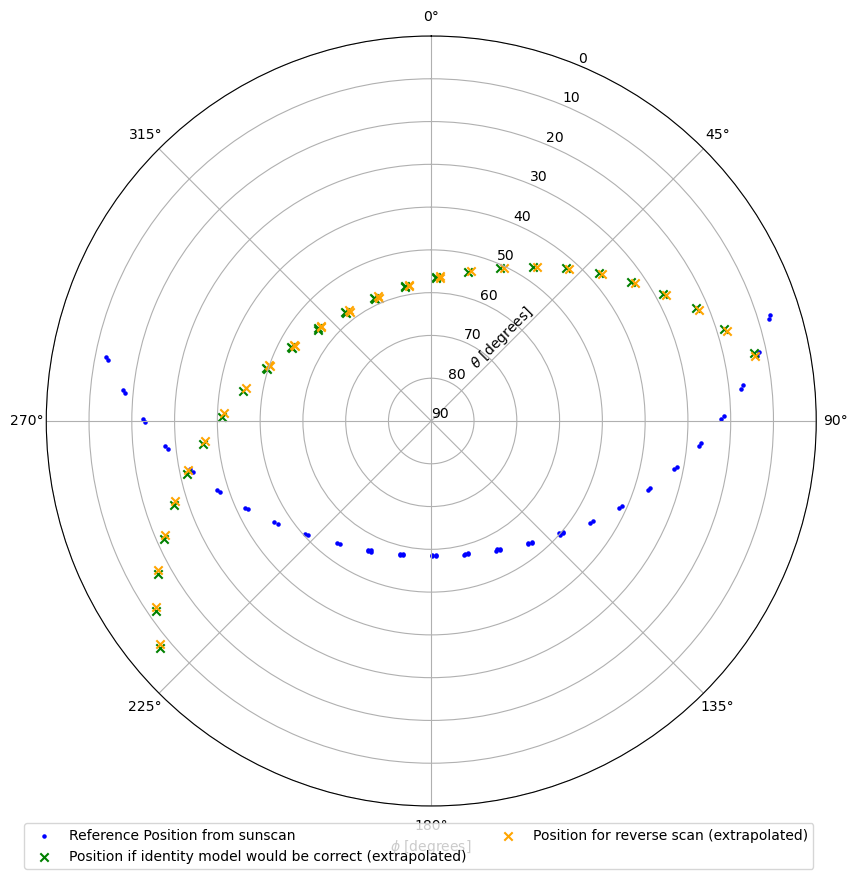

In [2]:
from sunscan.plotting import plot_calibrated_pairs
plot_calibrated_pairs(gamma_s, omega_s, azi_beam, elv_beam)

Now, we can start to estimate the six possible parameters of the scanner.
Before estimating, we have to define an initial guess for each one, as well as bounds.

In [ ]:
params_optimize= ["gamma_offset", "omega_offset", "alpha", "delta", "beta", "epsilon"]
params_guess={
    "gamma_offset": None, # if None, the optimizer will calculate a first guess of the northangle by itself.
    "omega_offset": None,
    "alpha": 0.0,
    "delta": 0.0,
    "beta": 0.0,
    "epsilon": 0.0,
}
params_bounds={
    "gamma_offset": [-0.2, 0.2], # if the initial guess for gamma_offset is determined by the optimizer, these bounds will apply relatively to this guess.
    "omega_offset": [-0.2, 0.2],
    "alpha": [-0.2, 0.2],
    "delta": [-0.2, 0.2],
    "beta": [-0.1, 0.1],
    "epsilon": [-2, 2],
}

In [4]:
from sunscan.estimators import ScannerEstimator
optimizer = ScannerEstimator(
    params_optimize=params_optimize,
    params_guess=params_guess,
    params_bounds=params_bounds,
)
scanner_model, rmse = optimizer.fit(gamma_s, omega_s, azi_beam, elv_beam, brute_force=False)

2025-08-09 19:52:30,110 - sunscan - INFO - Estimated gamma_offset: 202.9508, omega_offset: -0.0036
2025-08-09 19:52:30,111 - sunscan - INFO - Starting optimization
2025-08-09 19:52:43,923 - sunscan - INFO - Optimization Result:
gamma_offset: 202.7508
omega_offset: 0.0062
alpha: -0.0076
delta: 0.0598
beta: -0.1000
epsilon: 0.0124
2025-08-09 19:52:43,945 - sunscan - INFO - Initial objective: 0.206410
2025-08-09 19:52:43,946 - sunscan - INFO - Optimal objective: 0.101621


The next plot shows the results. The left panel includes only the correction by gamma_offset (aka northangle). The right plot includes the correction due to all fitted parameters.

Text(0.5, 1.0, 'Full correction with all parameters')

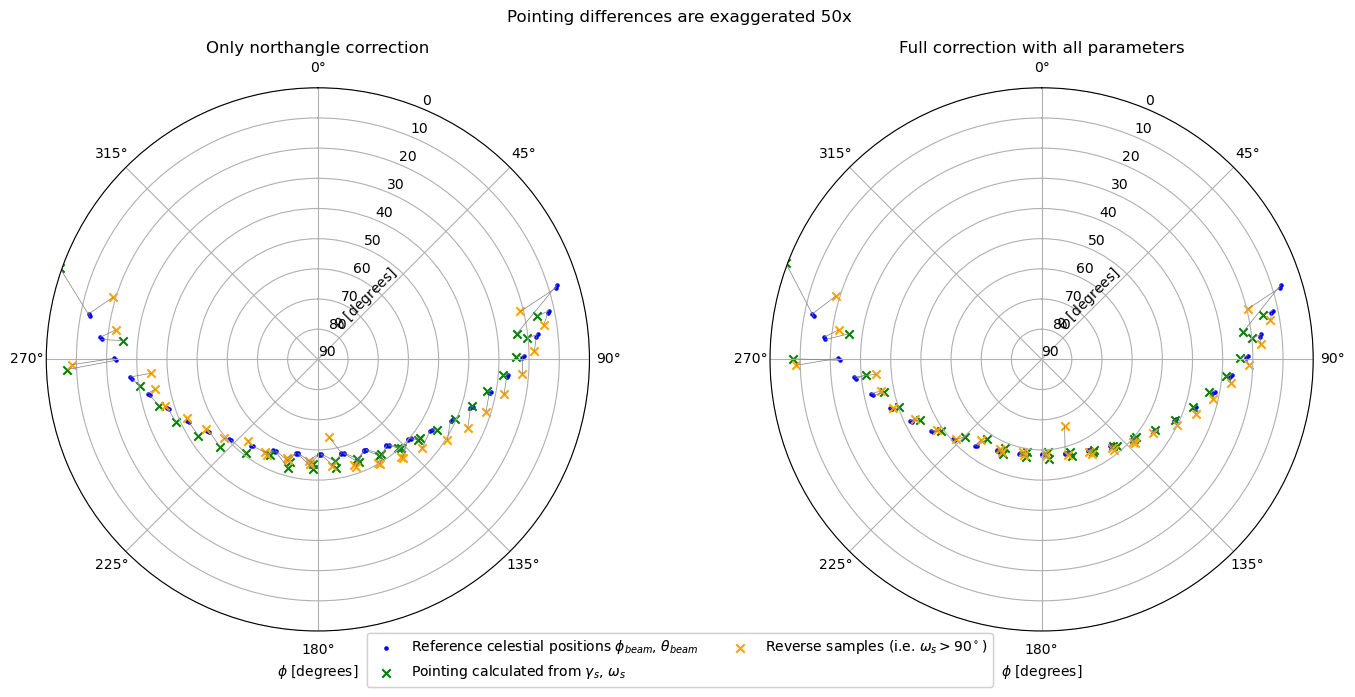

In [13]:
import matplotlib.pyplot as plt


import importlib
import sunscan.plotting
importlib.reload(sunscan.plotting)
from sunscan.plotting import plot_calibrated_pairs


fitted_params= scanner_model.get_params()
enhancement = 50
fig, ax = plt.subplots(1, 2, figsize=(15, 7), subplot_kw={'polar': True}, layout='tight')
fig.suptitle(f"Pointing differences are exaggerated {enhancement}x")
plot_calibrated_pairs(gamma_s, omega_s, azi_beam, elv_beam, ax=ax[0], gamma_offset=fitted_params['gamma_offset'], enhancement=enhancement)
ax[0].set_title("Only northangle correction")
plot_calibrated_pairs(gamma_s, omega_s, azi_beam, elv_beam, ax=ax[1], scanner_model=scanner_model, enhancement=enhancement)
ax[1].set_title("Full correction with all parameters")


The obtained scanner model allows us to answer two kind of question:
- forward: Given a scanner axis position ($\gamma$, $\omega$), where do we actually look in the sky?
- inverse: Given a position in the sky, to which scanner axis coordinates do we have to steer our scanner?

The inverse question has usually two solutions:

In [14]:
target_azi = 10
target_elv = 70
gamma, omega=scanner_model.inverse(0, 70, reverse=False)
gamma_rev, omega_rev=scanner_model.inverse(0, 70, reverse=True)
print(f"To point at azimuth {target_azi}° and elevation {target_elv}°, steer your scanner to either ({gamma:.2f}°, {omega:.2f}°) or ({gamma_rev:.2f}°, {omega_rev:.2f}°).")

To point at azimuth 10° and elevation 70°, steer your scanner to either (156.99°, 70.05°) or (337.47°, 109.93°).
